In [164]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
import pickle
from meep_material import lorentzfit
import os

In [165]:
resolution = 100
nfreq = 301
fcen = 1.75
df = 3.3

In [ ]:
import numpy as np
import meep as mp
import nlopt
from typing import Tuple

# lorentzfit 함수는 이미 정의되어 있어야 함 (여기선 너가 가지고 있다고 가정함)

def fit_material_from_csv(
    csv_path: str,
    wl_range_nm = [0.38, 0.72],
    eps_inf: float = 1.1,
    num_lorentzians: int = 3,
    num_repeat: int = 100,
    opt_tol: float = 1e-25,
    maxeval: int = 50000,
) -> mp.Medium:
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(csv_path)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf, E_sus, freq_range = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf, E_sus, freq_range
    
    # 데이터 불러오기
    mydata = np.genfromtxt(csv_path, delimiter=",")
    wl = mydata[:, 0]  # um
    n_complex = mydata[:, 1] + 1j * mydata[:, 2]
    eps_data = np.square(n_complex) - eps_inf  # 유전율에서 eps_inf 보정

    # 파장 범위 필터링
    wl_min, wl_max = wl_range_nm
    idx_start = np.where(wl > wl_min)[0][0]
    idx_end = np.where(wl < wl_max)[0][-1] + 1
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps_data[idx_start:idx_end]
    freqs_reduced = 1 / wl_reduced  # nm → 1/μm (Meep 단위)

    # 최적화 반복
    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)

    for m in range(num_repeat):
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, opt_tol, maxeval
        )
        print(f"[{m:2d}] RMS error: {mins[m]:.6e} — params: {ps[m, :]}")

    # 최적 피팅 결과 선택
    idx_opt = np.argmin(mins)
    popt = ps[idx_opt, :]
    print(f"\n>> Best fit RMS error = {mins[idx_opt]:.6e}")
    print(f">> Optimal parameters = {popt}")

    # mp.Medium 구성
    E_sus = []

    for i in range(num_lorentzians):
        sigma = popt[3 * i + 0]
        freq = popt[3 * i + 1]
        gamma = popt[3 * i + 2]

        if freq == 0:
            # Drude 항
            E_sus.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            # Lorentz 항
            sigma_adj = sigma / freq**2
            E_sus.append(mp.LorentzianSusceptibility(frequency=freq, gamma=gamma, sigma=sigma_adj))

    # 유효 주파수 범위 설정
    freq_min = 1 / wl_max
    freq_max = 1 / wl_min
    freq_range = mp.FreqRange(min=freq_min, max=freq_max)

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf, E_sus, freq_range), f)

    return eps_inf, E_sus, freq_range

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/Material_merged.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/Material_merged.csv"

eps_inf_sio2, suscept_sio2, freq_sio2 = fit_material_from_csv(csv_path=sio2_data_path, num_lorentzians=2,  wl_range_nm = [0.38, 0.72])
eps_inf_al, suscept_al, freq_al = fit_material_from_csv(csv_path=al_data_path, num_lorentzians=7)
eps_inf_andp, suscept_andp, freq_andp = fit_material_from_csv(csv_path=andp_data_path, num_lorentzians=5,  wl_range_nm = [0.4, 0.7])

Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/mat/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/Material_merged_fit.pkl


In [167]:
sio2 =  mp.Medium(epsilon = eps_inf_sio2,   E_susceptibilities = suscept_sio2, valid_freq_range=freq_sio2) # SiO2 ,
andp =  mp.Medium(epsilon = eps_inf_andp,   E_susceptibilities = suscept_andp) # aNDP ,
Al  =   mp.Medium(epsilon = eps_inf_al,     E_susceptibilities = suscept_al, valid_freq_range=freq_al)

In [168]:
### ----- Refractive index ----- ###,
# Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 ,
# aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP ,
# Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

Glass = sio2
aNDP = andp
Cathode = Al
CoverLayer_index = 1.9
ITO_m_index = 1.8
Alq3_index = 1.68

CoverLayer = mp.Medium(index=CoverLayer_index) # SiN ,
ITO_m = mp.Medium(index=ITO_m_index) 
Alq3 = mp.Medium(index = Alq3_index) 
Air = mp.Medium(index=1.0) # 공기,

PML_layer = 1

boundary_layers = [
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.Low),  # 좌측 PML,
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.High), # 우측 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.High), # 상단 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.Low), # 상단 PML,
]

Cathode_center = mp.Vector3(0, 0, 0)
Alq3_center = mp.Vector3(0, 0, 0)
aNDP_center = mp.Vector3(0, 0, 0)
ITO_center = mp.Vector3(0, 0, 0)
Cover_center = mp.Vector3(0, 0, 0)
Glass_center = mp.Vector3(0, 0, 0)

In [169]:
cell_size = mp.Vector3(5, 5,0)

geometry_fitting = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(10, 10, 0),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(10, 10, 0),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(10, 10, 0),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(10, 10, 0),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(10, 10, 0),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(10, 10, 0),
            material=Glass
        )
]

source_center = mp.Vector3(0,0,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0),
)]

In [170]:
# === 시뮬레이션 설정 === #
sim_fitting = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    default_material=Glass,
    sources=sources,
    resolution=resolution,
    eps_averaging=True,
    extra_materials=[Cathode, aNDP,Glass]
)

In [171]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, 0, 0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting = sim_fitting.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                  ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

<Axes: xlabel='X', ylabel='Y'>

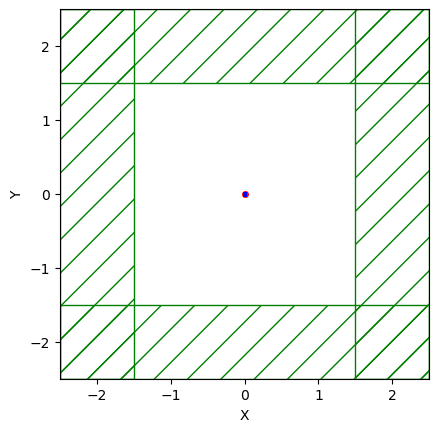

In [172]:
sim_fitting.plot2D()#output_plane=mp.Volume(center = mp.Vector3(0,0,0), size = mp.Vector3(0.1,0.1,)))

In [173]:
sim_fitting.run(until = 50)
# sim_fitting.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 20)

net_power_fitting = mp.get_fluxes(box_power_fitting)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00022316 s
Working in 2D dimensions.
Computational cell is 5 x 5 x 0 with resolution 100
time for set_epsilon = 0.127872 s
lorentzian susceptibility: frequency=9.51365, gamma=1.19842
lorentzian susceptibility: frequency=8.33172, gamma=0.349312
lorentzian susceptibility: frequency=12.8539, gamma=4.27338
lorentzian susceptibility: frequency=0.106609, gamma=0.00597233
lorentzian susceptibility: frequency=5.05282, gamma=0
lorentzian susceptibility: frequency=2.63601, gamma=0.275275
lorentzian susceptibility: frequency=4.79442, gamma=2.39603e-06
lorentzian susceptibility: frequency=4.87462, gamma=0
lorentzian susceptibility: frequency=4.77321, gamma=0.0786669
lorentzian susceptibility: frequency=11.9833, gamma=8.64311
drude susceptibility: frequency=1, gamma=0.155547
lorentzian susceptibility: frequency=1.47345, gamma=0.579822
lorentzian susceptibility: frequency=0.258842, gamma=5.8094
lorentzian susceptibility: frequen

/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/simulation.py:1660: RuntimeWarning: Note: your sources include frequencies outside the range of validity of the material models. This is fine as long as you eventually only look at outputs (fluxes, resonant modes, etc.) at valid frequencies.
  warnings.warn(warn_src, RuntimeWarning)


Meep progress: 4.99/50.0 = 10.0% done in 4.0s, 36.1s to go
on time step 998 (time=4.99), 0.00401224 s/step
Meep progress: 10.035/50.0 = 20.1% done in 8.0s, 31.9s to go
on time step 2007 (time=10.035), 0.00396519 s/step
Meep progress: 15.450000000000001/50.0 = 30.9% done in 12.0s, 26.9s to go
on time step 3090 (time=15.45), 0.00369414 s/step
Meep progress: 21.135/50.0 = 42.3% done in 16.0s, 21.9s to go
on time step 4227 (time=21.135), 0.00351872 s/step
Meep progress: 26.545/50.0 = 53.1% done in 20.0s, 17.7s to go
on time step 5310 (time=26.55), 0.00369616 s/step
Meep progress: 31.685000000000002/50.0 = 63.4% done in 24.0s, 13.9s to go
on time step 6338 (time=31.69), 0.00389153 s/step
Meep progress: 39.480000000000004/50.0 = 79.0% done in 28.0s, 7.5s to go
on time step 7897 (time=39.485), 0.00256744 s/step
Meep progress: 44.485/50.0 = 89.0% done in 32.0s, 4.0s to go
on time step 8898 (time=44.49), 0.00399641 s/step
Meep progress: 49.68/50.0 = 99.4% done in 36.0s, 0.2s to go
on time step 

In [174]:
from src_resolution import sourcepower

src_wavelengths, src_power = sourcepower(100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 100
time for set_epsilon = 0.527032 s
-----------
Meep progress: 8.69/20.0 = 43.4% done in 4.0s, 5.2s to go
on time step 1738 (time=8.69), 0.00230242 s/step
Meep progress: 17.41/20.0 = 87.0% done in 8.0s, 1.2s to go
on time step 3482 (time=17.41), 0.00229409 s/step
run 0 finished at t = 20.0 (4000 timesteps)
CSV 파일 저장 완료: sourcepower_res100.csv


In [175]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/One layer check/Onelayer/sio2.txt")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]
wavelengths = lumerical_data[:,0]
wavelengths = wavelengths* 1e+6

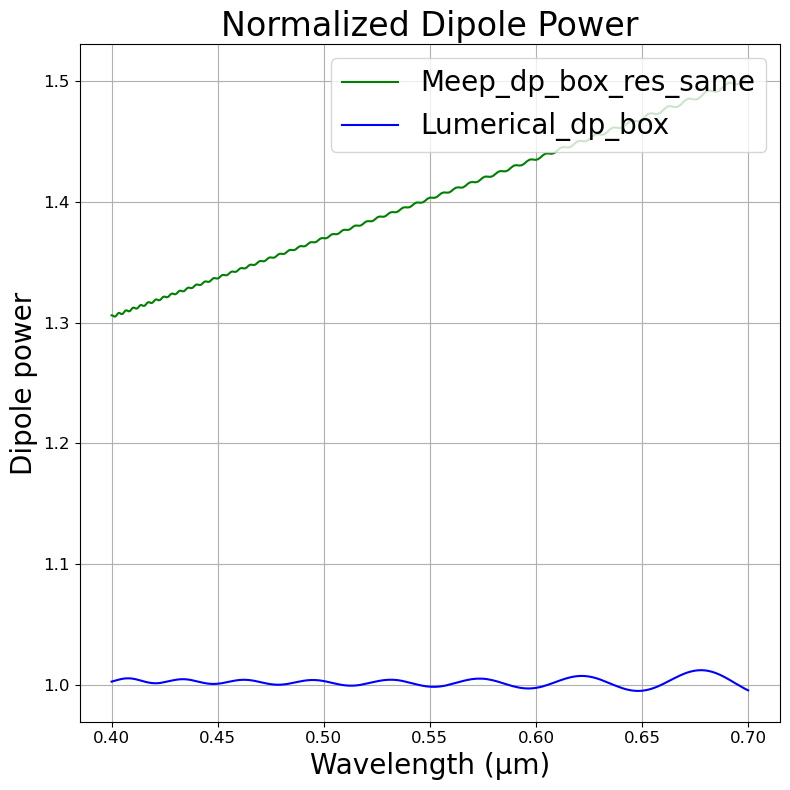

In [176]:
# dp_box / sourcepower 정규화
dp_fitting_100 = np.array(net_power_fitting) / src_power
# dp_fitting = np.array(net_power_fitting) / air_1000 

# wavelengths = 1 / np.array(mp.get_flux_freqs(box_power_fitting))

plt.figure(figsize=(8, 8))

# plot 순서
plt.plot(src_wavelengths, dp_fitting_100, label='Meep_dp_box_res_same', color='green')
plt.plot(wavelengths, lumerical, label='Lumerical_dp_box', color='blue')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Dipole power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(loc='upper right', fontsize=20, frameon=True,)
# plt.ylim (0.995, 1.01)
# 기타 설정
plt.grid(True)
plt.tight_layout()
plt.show()

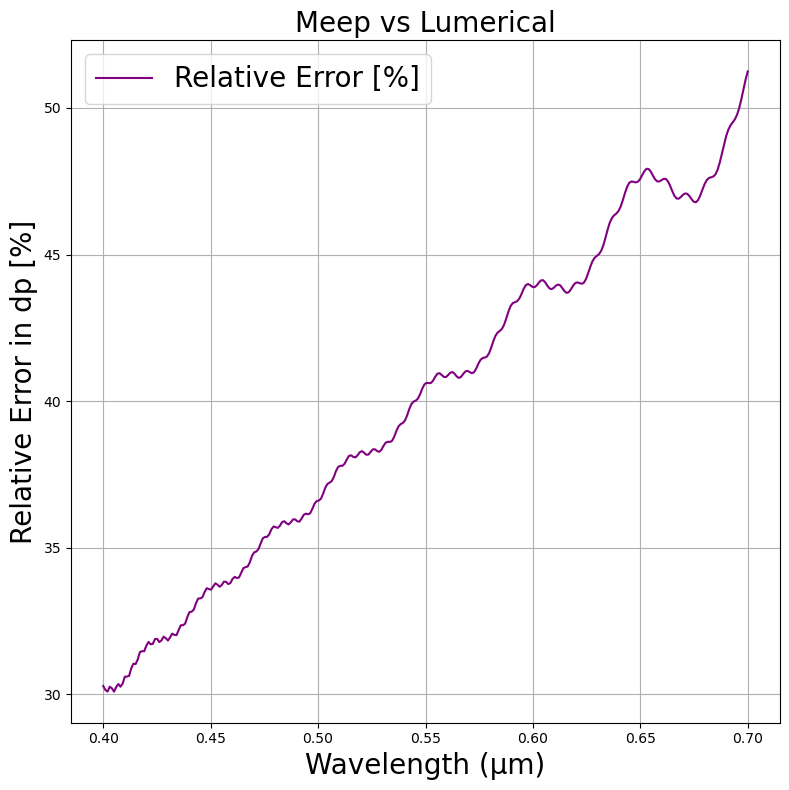

▶ 평균 상대 오차: 40.02%


In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- 1. 보간 함수 정의 ---
interp_meep = interp1d(src_wavelengths, dp_fitting_100, kind='cubic', bounds_error=False, fill_value="extrapolate")
interp_lumerical = interp1d(wavelengths, lumerical, kind='cubic', bounds_error=False, fill_value="extrapolate")

# --- 2. 공통 파장 축 설정 ---
wl_min = max(min(src_wavelengths), min(wavelengths))
wl_max = min(max(src_wavelengths), max(wavelengths))
wl_common = np.linspace(wl_min, wl_max, 300)

# --- 3. 보간 값 계산 ---
meep_vals = interp_meep(wl_common)
lumerical_vals = interp_lumerical(wl_common)

# --- 4. 상대 오차 (%) 계산 (분모 0 방지)
epsilon = 1e-12
percent_error = np.abs((meep_vals - lumerical_vals) / (lumerical_vals + epsilon)) * 100

# --- 5. 플로팅 ---
plt.figure(figsize=(8, 8))
plt.plot(wl_common, percent_error, color='purple', label='Relative Error [%]')

plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Relative Error in dp [%]", fontsize=20)
plt.title("Meep vs Lumerical", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("dp_percent_error.png", dpi=150)
plt.show()

# --- 6. 평균 상대 오차 출력 ---
print(f"▶ 평균 상대 오차: {np.mean(percent_error):.2f}%")
